# Stock Sentiment Analysis

Проєкт для аналізу новин та прогнозування руху цін акцій AAPL на основі сентимент-аналізу та технічного аналізу за допомогою методів машинного навчання. Вирішується задача мультикласової класифікації.

## 📋 Опис проєкту

Цей проєкт використовує новини про акції компаній та фінансові показники для прогнозування руху ціни акцій. Реалізовано кілька підходів:
- **TF-IDF + Logistic Regression / LGBM** - класичний підхід 
- **FinBERT** - сучасна трансформерна модель для глибокого розуміння контексту (донавчена на фінансових текстах)
- **LLM за API (GPT-3.5 turbo)** - модель, яка через API аналізує текст новин та генерує прогноз на основі фінансового сентименту.

## 📊 Датасет

Використовується датасет новин з Yahoo Finance, який містить:
- Новини/коментарі про акції (title, content)
- Фінансові дані (Open, High, Low, Close, Volume)
- Дати публікацій

**Статистика датасету:**
- Кількість записів: 15,975
- Кількість колонок: 13

## ⚡ Таргет
Усі підходи реалізовані для задачі мультикласової класифікації, де моделі повинні передбачити одну з трьох категорій руху ціни:
	•	UP – очікується зростання ціни
	•	DOWN – очікується падіння ціни
	•	NATURAL – без значних змін

## Посилання на дані
[Yahoo Finance Stock News Dataset на Kaggle](https://www.kaggle.com/datasets/deepakjoshi2k/yahoo-stock-prediction-by-news/data)

Тут задача бінарної класифікації (UP/DOWN)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [4]:
csv_path = "NEWS_YAHOO_stock_prediction.csv"
df = pd.read_csv(csv_path)
pd.set_option('display.max_colwidth', 50)

df.head(5)

Unnamed: 0 ticker        Date category  \
0           0   AAPL  2020-01-27  opinion   
1           1   AAPL  2020-01-27  opinion   
2           2   AAPL  2020-01-27  opinion   
3           3   AAPL  2020-01-27  opinion   
4           4   AAPL  2020-01-27  opinion   

                                               title  \
0  Apple Set To Beat Q1 Earnings Estimates  Tech ...   
1  Tech Daily  Intel Results  Netflix Surge  Appl...   
2  7 Monster Stock Market Predictions For The Wee...   
3  Apple Earnings Preview  5G Launch  Expanding S...   
4  Buy Surging Apple   Microsoft Stock Before Qua...   

                                             content       Open       High  \
0  Technology giant Apple   NASDAQ AAPL   is set ...  77.514999  77.942497   
1  The top stories in this digest are Intel s   N...  77.514999  77.942497   
2  S P 500  SPY \nThis week will be packed with e...  77.514999  77.942497   
3    Reports Q1 2020 results on Tuesday  Jan  28 ...  77.514999  77.942497   
4  On today s episode of Full Court Finance here ...  77.514999  77.942497   

         Low      Close  Adj Close     Volume  label  
0  76.220001  77.237503  75.793358  161940000      0  
1  76.220001  77.237503  75.793358  161940000      0  
2  76.220001  77.237503  75.793358  161940000      0  
3  76.220001  77.237503  75.793358  161940000      0  
4  76.220001  77.237503  75.793358  161940000      0

### EDA (Exploratory Data Analysis)

In [7]:
# Розмір датасету
print("Кількість рядків:", df.shape[0])
print("Кількість колонок:", df.shape[1])

print("Типи даних у колонках:")
print(df.dtypes, "\n")

print("Кількість пропущених значень у колонках:")
print(df.isnull().sum(), "\n")

print("Дублікати:", df.duplicated().sum())

Кількість рядків: 15975
Кількість колонок: 13
Типи даних у колонках:
Unnamed: 0      int64
ticker         object
Date           object
category       object
title          object
content        object
Open          float64
High          float64
Low           float64
Close         float64
Adj Close     float64
Volume          int64
label           int64
dtype: object 

Кількість пропущених значень у колонках:
Unnamed: 0    0
ticker        0
Date          0
category      0
title         0
content       0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
label         0
dtype: int64 

Дублікати: 0


Датасет містить 15 975 рядків та 13 колонок. Він поєднує як фінансові, так і текстові дані:

	•	ticker, Date — ідентифікація активів та дата спостереження;
	•	category, title, content — категорія новини, заголовок та текст новини;
	•	Open, High, Low, Close, Adj Close, Volume — фінансові показники акцій;
	•	label — запропонована цільова змінна для моделі прогнозування руху ціни - буде далі змінена.

Всі колонки не містять пропусків, дубльованих рядків немає.

In [10]:
print(f"Період даних: {df['Date'].min()} - {df['Date'].max()}")
print(f"Кількість днів: {df['Date'].nunique()}")

Період даних: 2012-07-23 - 2020-01-27
Кількість днів: 1654


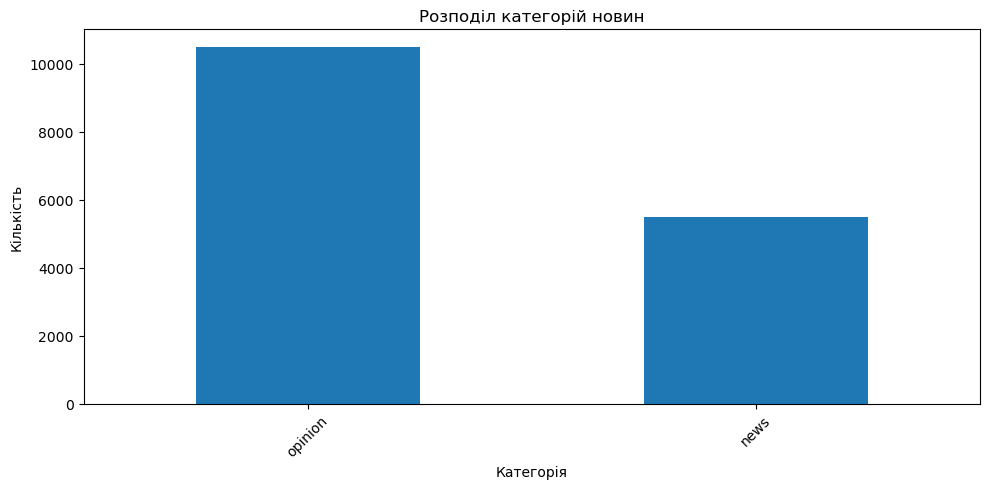

category
opinion    65.646322
news       34.353678
Name: proportion, dtype: float64

In [12]:
# Розподіл категорій новин
plt.figure(figsize=(10, 5))
df['category'].value_counts().plot(kind='bar')
plt.title('Розподіл категорій новин')
plt.xlabel('Категорія')
plt.ylabel('Кількість')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

df['category'].value_counts(normalize=True) * 100

In [14]:
print("Новин на день:")
print(df.groupby('Date').size().describe())

Новин на день:
count    1654.000000
mean        9.658404
std        13.591393
min         1.000000
25%         3.000000
50%         6.000000
75%        11.000000
max       116.000000
dtype: float64


Дані нерівномірно розподілені по днях, є дні з дуже великою кількістю новин, що може впливати на моделювання.

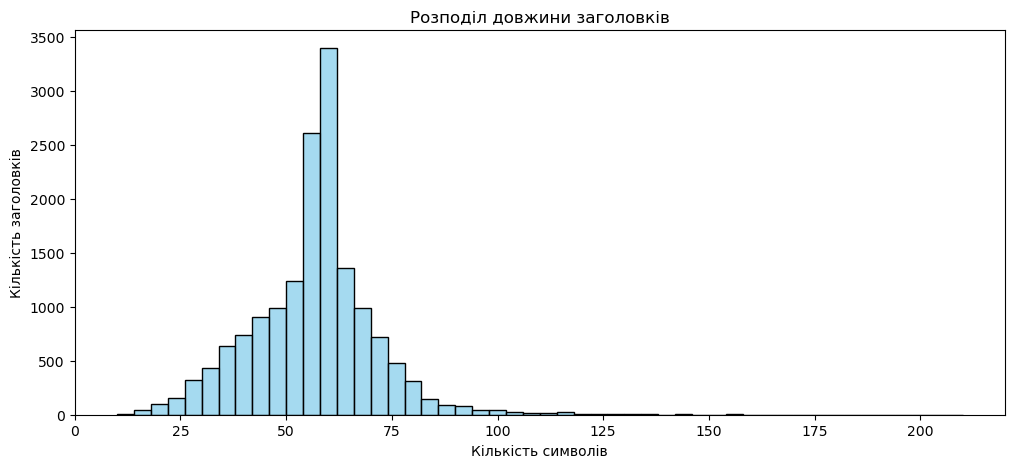

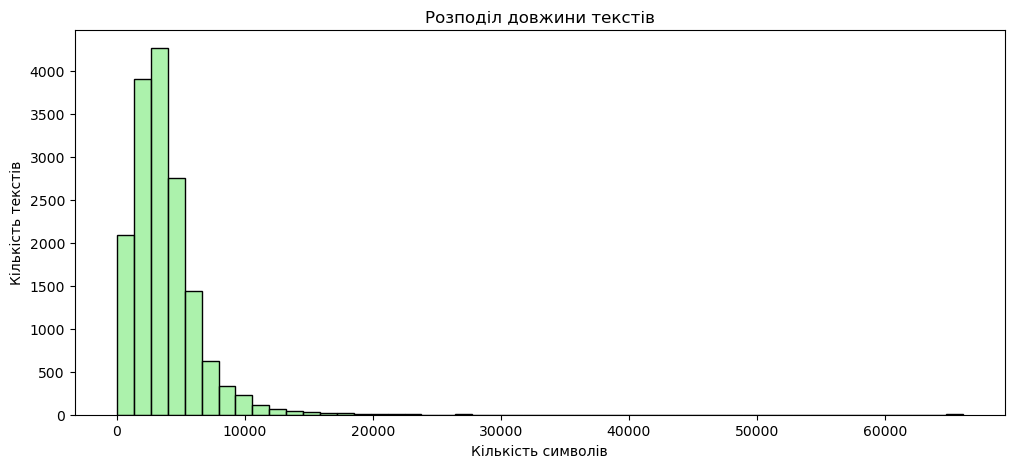

In [17]:
import seaborn as sns
# Додаємо ознаки довжини текстів
df['title_len'] = df['title'].apply(len)
df['content_len'] = df['content'].apply(len)

# Розподіл довжини заголовків
plt.figure(figsize=(12,5))
sns.histplot(df['title_len'], bins=50, color='skyblue')
plt.title("Розподіл довжини заголовків")
plt.xlabel("Кількість символів")
plt.ylabel("Кількість заголовків")
plt.show()

# Розподіл довжини текстів
plt.figure(figsize=(12,5))
sns.histplot(df['content_len'], bins=50, color='lightgreen')
plt.title("Розподіл довжини текстів")
plt.xlabel("Кількість символів")
plt.ylabel("Кількість текстів")
plt.show()

In [18]:
!pip install wordcloud

[nltk_data] Downloading package stopwords to /Users/elena/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


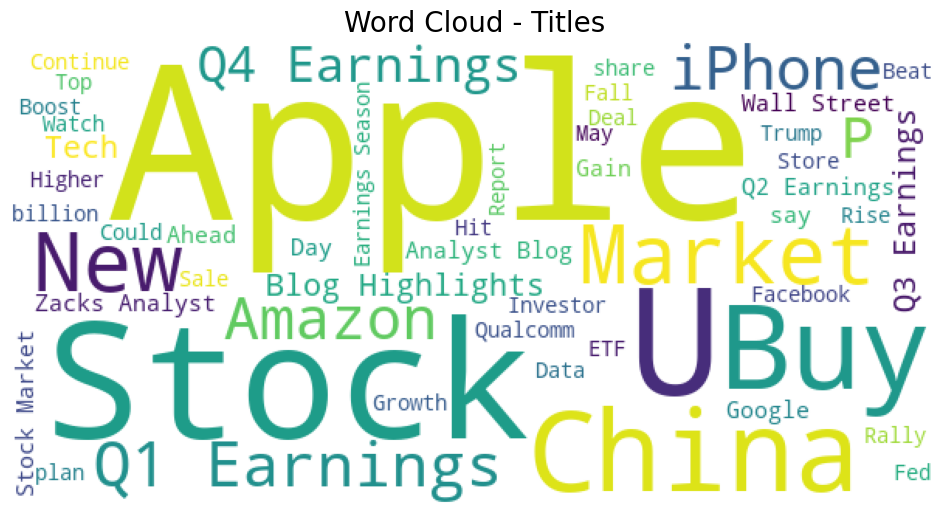

In [20]:
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

def create_wordcloud(text, stopwords_list, title='Word Cloud'):
    wc = WordCloud(
        background_color='white',
        #colormap='viridis',
        stopwords=stopwords_list,
        width=600,
        height=300,
        max_words=80,  # менше слів
        relative_scaling=0.5,
        min_font_size=14
    ).generate(text)

    plt.figure(figsize=(12, 8))
    plt.axis("off")
    plt.title(title, fontsize=20)
    plt.imshow(np.array(wc.to_image()))
    plt.show()

# Word Cloud для title
text_title = ' '.join(df['title'].tolist())
create_wordcloud(text_title, stopwords_list, title='Word Cloud - Titles')



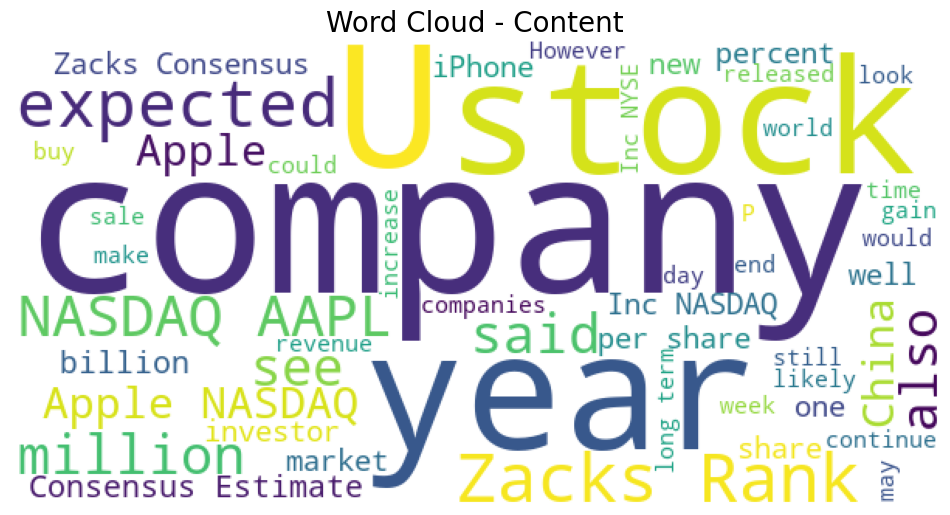

In [21]:
# Word Cloud для content
text_content = ' '.join(df['content'].tolist())
create_wordcloud(text_content, stopwords_list, title='Word Cloud - Content')

Word Cloud показує, що у заголовках та текстах новин переважають зрозумілі та логічні фінансові терміни.

#### Створення таргету

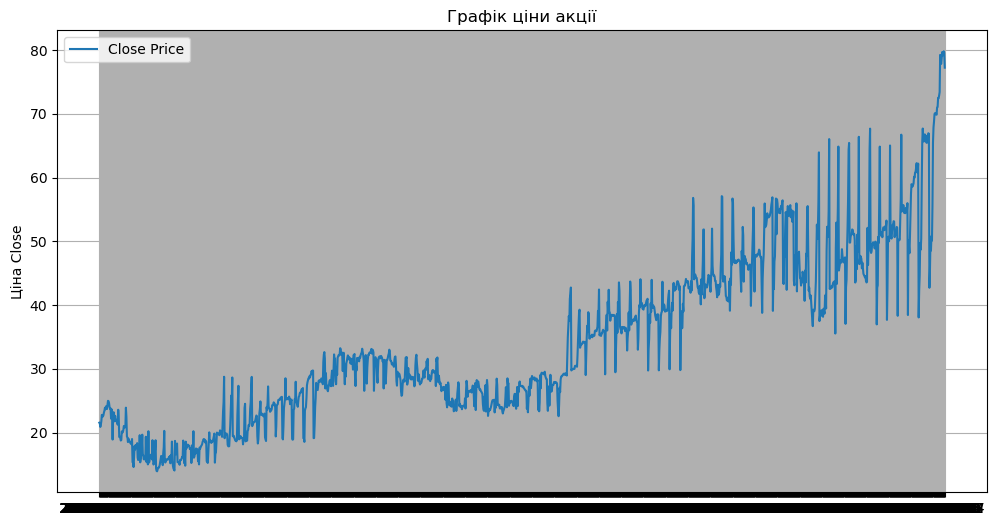

In [25]:
df = df.sort_values('Date')
plt.figure(figsize=(12,6))
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.title('Графік ціни акції')
plt.ylabel('Ціна Close')
plt.legend()
plt.grid(True)
plt.show()

Свічковий графік ціни AAPL

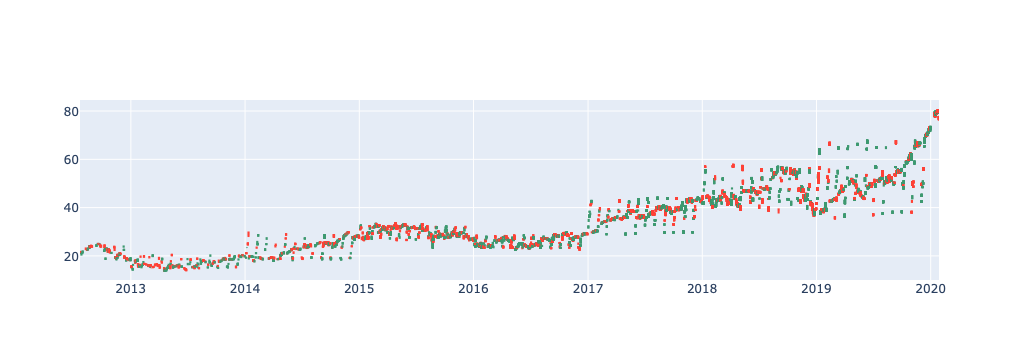

In [28]:
import plotly.graph_objects as go

ohlc_df = df[['Date', 'Open', 'High', 'Low', 'Close']].copy()

ohlc_df['Date'] = pd.to_datetime(ohlc_df['Date'])

ohlc_df.set_index('Date', inplace=True)
ohlc_df.sort_index(inplace=True)

fig = go.Figure(
    data=[go.Candlestick(
        x=ohlc_df.index,
        open=ohlc_df['Open'],
        high=ohlc_df['High'],
        low=ohlc_df['Low'],
        close=ohlc_df['Close']
    )]
)

fig.update_layout(xaxis_rangeslider_visible=False)
fig.show()

![](2.png)

![](1.png)

Визначення таргету:  
Мета цього проекту — прогнозувати напрямок зміни ціни акції на наступний торговий день (оскільки в датасеті маємо пропущені дні) на основі історичних фінансових та новинних даних.  
Таргет формується на основі процентної зміни ціни закриття між поточним та наступним торговим днем:

$$
\text{Price\_Change\_Pct} = \frac{\text{Close}_{t+1} - \text{Close}_t}{\text{Close}_t} \times 100
$$

Далі ця змінна переводиться у категорії:

- UP — якщо $\text{Price\_Change\_Pct} > 1$  
- DOWN — якщо $\text{Price\_Change\_Pct} < -1$  
- NEUTRAL — якщо зміна ціни знаходиться між цими порогами

Таким чином, ми формалізуємо задачу як задачу мультикласової класифікації з трьома класами.

У даних присутні пропуски — відсутні окремі дні, включно з періодами по 5–7 днів поспіль. При формуванні таргету (наступне спостереження) я проігнорувала ці пропуски і використовувала у якості “наступного дня” найближче наявне спостереження. Оскільки насправді ці дані доступні і можна більш ретельно побудувати початковий датасет, модель прогнозує наступний доступний день, а не календарний день.

In [35]:
# Спочатку сортуємо за датою
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Беремо ціну закриття наступного дня
close_per_day = df.groupby('Date')['Close'].last().reset_index()
close_per_day['Next_Close'] = close_per_day['Close'].shift(-1)

# Об’єднуємо назад з усіма новинами
df = df.merge(close_per_day[['Date', 'Next_Close']], on='Date', how='left')

# Таргет — відсоткова зміна ціни
df['Price_Change_Pct'] = ((df['Next_Close'] - df['Close']) / df['Close']) * 100

# Перевірка
print(df[['Date','Close','Next_Close','Price_Change_Pct']].head(10))
print(df['Price_Change_Pct'].describe())

        Date      Close  Next_Close  Price_Change_Pct
0 2012-07-23  21.565357   21.461430         -0.481916
1 2012-07-23  21.565357   21.461430         -0.481916
2 2012-07-23  21.565357   21.461430         -0.481916
3 2012-07-24  21.461430   20.898571         -2.622654
4 2012-07-27  20.898571   21.251072          1.686723
5 2012-07-30  21.251072   21.812857          2.643561
6 2012-07-31  21.812857   22.791786          4.487853
7 2012-07-31  21.812857   22.791786          4.487853
8 2012-08-10  22.791786   22.560356         -1.015410
9 2012-08-14  22.560356   22.529642         -0.136141
count    15967.000000
mean        -0.023666
std          8.097667
min        -41.365024
25%         -1.515758
50%          0.005711
75%          1.786585
max         37.386597
Name: Price_Change_Pct, dtype: float64


Таргет Price_Change_Pct — це процентна зміна ціни закриття наступного дня. Середнє значення близьке до нуля, більшість днів має невеликі коливання (-1.5% … +1.8%), але трапляються і великі зміни (мінус 41% до плюс 37%).

In [38]:
def price_to_class(pct):
    if pct < -1:       # падіння більше 1%
        return 'DOWN'
    elif pct > 1:      # зростання більше 1%
        return 'UP'
    else:
        return 'NEUTRAL'  # нейтральне коливання

# Застосовуємо функцію до кожного дня
df['target'] = df['Price_Change_Pct'].apply(price_to_class)

# Статистика по класах
print(df['target'].value_counts())

target
NEUTRAL    5763
UP         5355
DOWN       4857
Name: count, dtype: int64


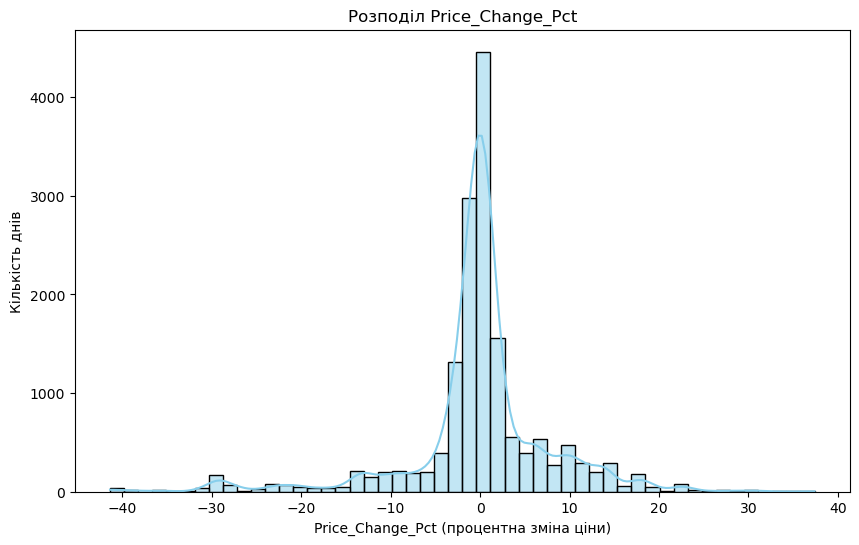

In [40]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.histplot(df['Price_Change_Pct'], bins=50, kde=True, color='skyblue')
plt.title('Розподіл Price_Change_Pct')
plt.xlabel('Price_Change_Pct (процентна зміна ціни)')
plt.ylabel('Кількість днів')
plt.show()

Ми перекодували процентну зміну ціни у категоріальний таргет з трьома класами: DOWN (падіння), UP (зростання) та NEUTRAL (незначне коливання).
Вибір 1% як порога для розподілу на класи DOWN / NEUTRAL / UP — це умовне рішення, яке робиться, щоб виділити значущі зміни ціни від дрібних коливань.
Було кілька альтернатив: можна було обрати інші пороги (наприклад ±0.5% або ±2%), залишити бінарний таргет, або передбачати відсоткову зміну ціни як регресійну задачу і потім розбивати на класи.


### Розподіл даних на тренувальний, валідаційний та тестовий набори

In [44]:
# Отримуємо унікальні дати
unique_dates = sorted(df['Date'].unique())
n_dates = len(unique_dates)
print(f"Всього унікальних дат: {n_dates}")

# Розділяємо по датам (не по індексах)
train_dates = unique_dates[:int(n_dates * 0.7)]
val_dates = unique_dates[int(n_dates * 0.7):int(n_dates * 0.85)]
test_dates = unique_dates[int(n_dates * 0.85):]

# Створюємо піднабори
train_df = df[df['Date'].isin(train_dates)].copy()
val_df = df[df['Date'].isin(val_dates)].copy()
test_df = df[df['Date'].isin(test_dates)].copy()

print(f"Розміри наборів:")
print(f"Train: {train_df.shape[0]:,} записів ({len(train_dates)} днів)")
print(f"Val:   {val_df.shape[0]:,} записів ({len(val_dates)} днів)")
print(f"Test:  {test_df.shape[0]:,} записів ({len(test_dates)} днів)")


Всього унікальних дат: 1654
Розміри наборів:
Train: 8,285 записів (1157 днів)
Val:   3,727 записів (248 днів)
Test:  3,963 записів (249 днів)


Я розділила дані по датах, щоб уникнути “витоку майбутньої інформації” у тренувальний набір. 70% днів пішли у Train, наступні 15% — у Validation, останні 15% — у Test

In [47]:
# Розподіл таргету по класах

def target_counts(df, target_col='target'):
    counts = df[target_col].value_counts()
    percents = df[target_col].value_counts(normalize=True) * 100
    result = pd.DataFrame({'кількість': counts, 'частка (%)': percents})
    return result

# Тренувальний набір
print("Тренувальний набір:")
print(target_counts(train_df))

# Валідаційний набір
print("\nВалідаційний набір:")
print(target_counts(val_df))

# Тестовий набір
print("\nТестовий набір:")
print(target_counts(test_df))

Тренувальний набір:
         кількість  частка (%)
target                        
NEUTRAL       3183   38.418829
DOWN          2622   31.647556
UP            2480   29.933615

Валідаційний набір:
         кількість  частка (%)
target                        
UP            1345   36.088006
NEUTRAL       1257   33.726858
DOWN          1125   30.185135

Тестовий набір:
         кількість  частка (%)
target                        
UP            1530   38.607116
NEUTRAL       1323   33.383800
DOWN          1110   28.009084


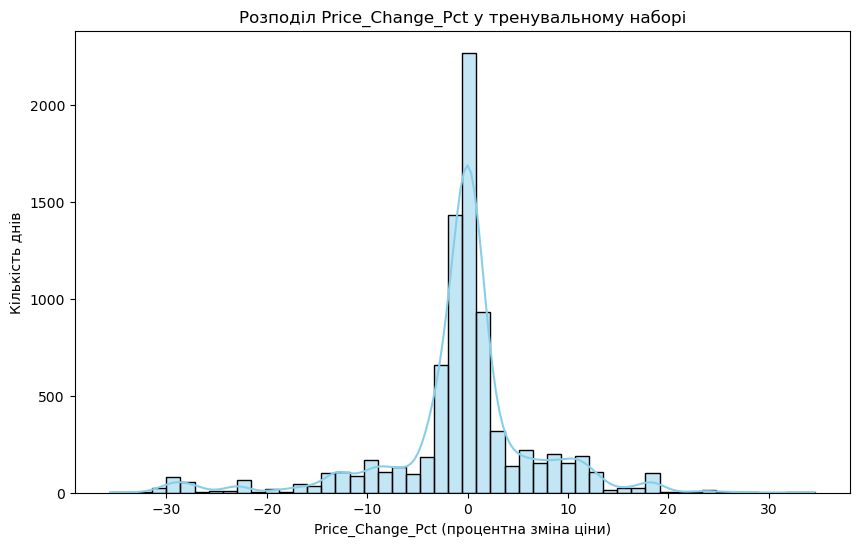

In [49]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.histplot(train_df['Price_Change_Pct'], bins=50, kde=True, color='skyblue')
plt.title('Розподіл Price_Change_Pct у тренувальному наборі')
plt.xlabel('Price_Change_Pct (процентна зміна ціни)')
plt.ylabel('Кількість днів')
plt.show()

### Feature Engineering

In [58]:
#!pip install vaderSentiment

In [60]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd

analyzer = SentimentIntensityAnalyzer()

def add_features(df):
    """
    Додає нові ознаки до DataFrame:
    - Дата: день тижня, вихідний, місяць
    - Категорії: бінарна ознака (news/opinion)
    - Текстові ознаки: довжина заголовка та тексту, кількість слів, наявність чисел
    - Sentiment score (compound)
    """

    # Дата
    df['date'] = pd.to_datetime(df['Date'])
    df['dow'] = df['date'].dt.dayofweek            # день тижня (0=понеділок)
    df['is_weekend'] = df['dow'].isin([5,6]).astype(int)  # вихідний: 1 – так, 0 – ні
    df['month'] = df['date'].dt.month             # місяць

    # Категорії
    df['category_bin'] = df['category'].map({'news': 1, 'opinion': 0})

    # Заголовок
    df['title_len'] = df['title'].str.len()        # довжина заголовка (символи)
    df['title_words'] = df['title'].str.split().str.len()   # кількість слів у заголовку
    df['title_has_number'] = df['title'].str.contains(r'\d').astype(int)  # чи є числа

    # Контент
    df['content_len'] = df['content'].str.len()    # довжина тексту
    df['content_words'] = df['content'].str.split().str.len()  # кількість слів
    df['num_ratio'] = df['content'].str.count(r'\d') / (df['content_words'] + 1)  # частка чисел

    # Sentiment
    df['sentiment'] = df['content'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

    return df



def create_price_features(df):
    """
    Створює price features. Максимальне вікно = 14 днів.
    Працює з колонками: Open, High, Low, Close, Volume
    """
    import pandas as pd
    import numpy as np

    df = df.copy()
    current_cols = df.columns

    # LAG FEATURES
    for col in ['Close','Open','High','Volume']:
        for lag in [1, 2, 3, 5, 7, 10, 14]:
            df[f'{col}_lag_{lag}'] = df[col].shift(lag)

    # RETURNS
    for period in [1, 3, 5, 7, 10, 14]:
        df[f'Return_{period}d'] = df['Close'].pct_change(period).shift(1) * 100
    df['Gap'] = (df['Open'] - df['Close_lag_1']) / df['Close_lag_1'] * 100
    df['Prev_Intraday_Return'] = (df['Close_lag_1'] - df['Open_lag_1']) / df['Open_lag_1'] * 100

    # HIGH-LOW RANGE
    df['HL_Range_lag_1'] = (df['High'].shift(1) - df['Low'].shift(1)) / df['Low'].shift(1) * 100
    for w in [1, 3, 5, 7, 10]:
        df[f'HL_Range_MA{w}'] = df['HL_Range_lag_1'].rolling(w).mean()

    true_range = pd.concat([
        (df['High'].shift(1) - df['Low'].shift(1)).abs(),
        (df['High'].shift(1) - df['Close'].shift(2)).abs(),
        (df['Low'].shift(1) - df['Close'].shift(2)).abs()
    ], axis=1).max(axis=1)
    df['ATR_7'] = true_range.rolling(7).mean()
    df['ATR_14'] = true_range.rolling(14).mean()

    # MOVING AVERAGES
    for w in [5, 7, 10, 14]:
        df[f'MA_{w}'] = df['Close'].shift(1).rolling(w).mean()
        df[f'Price_vs_MA{w}'] = (df['Close_lag_1'] - df[f'MA_{w}']) / df[f'MA_{w}'] * 100
        df[f'Above_MA{w}'] = (df['Close_lag_1'] > df[f'MA_{w}']).astype(int)

    # VOLATILITY
    for w in [2, 5, 7, 10, 14]:
        df[f'Volatility_{w}d'] = df['Close'].shift(1).pct_change().rolling(w).std() * 100

    # RSI
    def calc_rsi(series, period=14):
        delta = series.diff()
        gain = delta.where(delta>0,0).rolling(period).mean()
        loss = -delta.where(delta<0,0).rolling(period).mean()
        rs = gain / loss
        return 100 - (100 / (1 + rs))
    df['RSI_7'] = calc_rsi(df['Close'].shift(1), 7)
    df['RSI_14'] = calc_rsi(df['Close'].shift(1), 14)

    # MACD
    ema_8 = df['Close'].shift(1).ewm(span=8, adjust=False).mean()
    ema_12 = df['Close'].shift(1).ewm(span=12, adjust=False).mean()
    df['MACD'] = ema_8 - ema_12
    df['MACD_Signal'] = df['MACD'].ewm(span=5, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['MACD_Signal']

    # BOLLINGER BANDS
    ma_14 = df['Close'].shift(1).rolling(14).mean()
    std_14 = df['Close'].shift(1).rolling(14).std()
    df['BB_Upper'] = ma_14 + 2*std_14
    df['BB_Lower'] = ma_14 - 2*std_14
    df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / ma_14 * 100
    df['BB_Position'] = (df['Close_lag_1'] - df['BB_Lower']) / (df['BB_Upper'] - df['BB_Lower']) * 100

    # VOLUME FEATURES
    for w in [5,7,14]:
        df[f'Volume_MA{w}'] = df['Volume'].shift(1).rolling(w).mean()
    df['Volume_Ratio'] = df['Volume_lag_1'] / df['Volume_MA7']
    df['Volume_Spike'] = (df['Volume_Ratio'] > 2).astype(int)
    df['Volume_Trend'] = (df['Volume_MA5'] - df['Volume_MA14']) / df['Volume_MA14'] * 100

    # TREND INDICATORS
    for w in [7,14]:
        df[f'Distance_from_High_{w}d'] = (df['Close_lag_1'] - df['Close'].shift(1).rolling(w).max()) / df['Close'].shift(1).rolling(w).max() * 100
        df[f'Distance_from_Low_{w}d'] = (df['Close_lag_1'] - df['Close'].shift(1).rolling(w).min()) / df['Close'].shift(1).rolling(w).min() * 100

    # PRICE PATTERNS
    df['Daily_Change'] = df['Close'].pct_change().shift(1)
    df['Daily_Change_Abs'] = abs(df['Daily_Change'])
    df['Up_Days_5'] = (df['Daily_Change']>0).shift(1).rolling(5).sum()
    df['Down_Days_5'] = (df['Daily_Change']<0).shift(1).rolling(5).sum()
    df['Price_Direction'] = np.sign(df['Daily_Change'])
    df['Higher_High_5d'] = (df['Close_lag_1'] > df['Close'].shift(1).rolling(5).max().shift(1)).astype(int)
    df['Lower_Low_5d'] = (df['Close_lag_1'] < df['Close'].shift(1).rolling(5).min().shift(1)).astype(int)

    # OPEN-CLOSE RELATION
    df['Close_Above_Open_lag_1'] = (df['Close_lag_1'] > df['Open_lag_1']).astype(int)

    # Заповнення NaN (не актуальне)
    df = df.ffill()

    price_features = [col for col in df.columns if col not in current_cols]
    return df, price_features


Я додала нові ознаки, щоб модель краще розуміла контекст: дата (день тижня, вихідний, місяць), категорія новини (новина або думка), характеристики заголовку (довжина, кількість слів, наявність чисел), характеристики тексту (довжина, кількість слів, частка чисел) та оцінку настрою тексту (sentiment) за допомогою VADER, де значення коливаються від -1 (дуже негативний) до 1 (дуже позитивний).

Створила набір price features, які описують історичну поведінку ціни та обсягів торгів, що допомагає моделі передбачати напрямок руху ціни (UP/DOWN/NEUTRAL). Основні групи ознак:

	•	Лаги (Lags): ціна та обсяг попередніх днів, щоб модель бачила історію.
	•	Returns: відсоткова зміна ціни за різні періоди, показує темп росту/падіння.
	•	Gap та Prev_Intraday_Return: різниця відкриття та закриття, дає інформацію про ранкові рухи.
	•	High-Low Range та HL_Range_MA: амплітуда коливань за день і її середнє, оцінює волатильність.
	•	ATR (Average True Range): середня волатильність за 7 та 14 днів, показує ризик руху ціни.
	•	MA та Price_vs_MA: ковзні середні та відхилення від них, допомагають бачити тренд.
	•	Volatility: стандартне відхилення відсоткових змін ціни, оцінює нестабільність.
	•	RSI: індикатор перекупленості/перепроданості, на основі росту/падіння ціни.
	•	MACD та MACD_Histogram: показують тренд та його силу.
	•	Bollinger Bands: верхня/нижня межа коливань ціни, ширина та позиція ціни відносно них.
	•	Volume_MA, Volume_Ratio, Volume_Spike, Volume_Trend: оцінка обсягу торгів та його аномалій.
	•	Distance_from_High/Low: наскільки ціна віддалена від локальних максимумів/мінімумів, оцінює силу тренду.
	•	Price Patterns (Daily_Change, Up/Down Days, Higher High, Lower Low): короткострокові патерни руху ціни.
	•	Close_Above_Open_lag_1: чи закриття попереднього дня було вище відкриття, показує ранковий настрій ринку.


In [64]:
# Групуємо по даті
df_daily = df.groupby('Date').agg({
    'Close': 'last',
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Volume': 'last'
}).reset_index()

df_daily = df_daily.sort_values('Date').reset_index(drop=True)

# 1. Створити price features
df_price, price_cols = create_price_features(df_daily)

# 2. Витягти тільки price колонки
df_price = df_price[['Date'] + price_cols]

train_df = add_features(train_df)
val_df = add_features(val_df)
test_df = add_features(test_df)

# 2. Merge до train/val/test по колонці Date
train_df = train_df.merge(df_price, on='Date', how='left')
val_df = val_df.merge(df_price, on='Date', how='left')
test_df = test_df.merge(df_price, on='Date', how='left')

train_df = train_df.dropna()
#val_df   = val_df.dropna() # відсутні, оскільки рахую price features на всьому датасеті
test_df  = test_df.dropna()

Я створила фінансові ознаки на основі цін акцій та обсягів на всьому датасеті щоб уникнути зайвих пропусків зсередини. На початку датасету з’явились пропуски, бо для деяких ознак потрібні дані попередніх днів — їх видалено. Також видалено пропуски наприкінці timeseries, що зʼявилися при визначенні таргету.

### Передобробка текстових та числових даних

In [66]:
import re

def preprocess_text(text):

    # Переводимо в нижній регістр
    text = text.lower()

    # Прибираємо зайві пробіли, переноси рядків, табуляції
    text = re.sub(r'\s+', ' ', text)

    # Видаляємо «сміття», але ЗАЛИШАЄМО:
    # букви, цифри, точки, відсотки та пробіли
    text = re.sub(r'[^a-z0-9\.\%\s]', ' ', text)

    return text.strip()

# Застосовуємо до заголовків
train_df['title_clean'] = train_df['title'].apply(preprocess_text)
val_df['title_clean'] = val_df['title'].apply(preprocess_text)
test_df['title_clean'] = test_df['title'].apply(preprocess_text)

# Застосовуємо до текстів
train_df['content_clean'] = train_df['content'].apply(preprocess_text)
val_df['content_clean'] = val_df['content'].apply(preprocess_text)
test_df['content_clean'] = test_df['content'].apply(preprocess_text)

# Перевіряємо результат
print(train_df[['title_clean', 'content_clean']].head())

                                          title_clean  \
24         stock breakouts breakdowns and in betweens   
25  markets trade higher through most of session p...   
26  u s stocks still the place to be for global in...   
27  attention bulls you may be about to be majorly...   
28                           apple call spread update   

                                        content_clean  
24  the overall market s slow action hides all sor...  
25  u s stocks rose slightly yesterday with the ma...  
26  despite last friday s disappointing jobs repor...  
27  let s look at the markets where the bulls appe...  
28  with a huge rally apple aapl has started to ju...  


На етапі базової передобробки тексту було виконано мінімальне очищення без лематизації та видалення стоп-слів. Текст приводився до нижнього регістру, видалялися зайві пробіли та небуквені символи, при цьому числові значення, відсотки та десяткові числа були збережені, оскільки вони несуть важливу фінансову інформацію (прибутки, відсоткові зміни, обсяги), але на жаль були відсутні в початковому датасеті.

Лематизація та видалення стоп-слів не застосовувалися навмисно, оскільки:

	- у фінансових текстах форма слова та контекст можуть мати значення;
	- збереження оригінальної структури тексту дозволяє уникнути втрати сигналів, важливих для прогнозування напрямку руху ціни.


In [68]:
from sklearn.preprocessing import StandardScaler

# колонки для стандартизації
num_features = ['dow', 'month',
                'title_len', 'title_words', 'title_has_number',
                'content_len', 'content_words', 'num_ratio'] + price_cols

scaler = StandardScaler()

# навчання scaler на train_df и трансформування
train_scaled = scaler.fit_transform(train_df[num_features])
val_scaled   = scaler.transform(val_df[num_features])
test_scaled  = scaler.transform(test_df[num_features])

# бінарні колонки
bin_features = ['is_weekend', 'sentiment', 'category_bin']  # sentiment уже [-1;1]

Я стандартизувала числові ознаки, щоб вони мали середнє 0 та стандартне відхилення 1. Це потрібно для стабільного навчання логістичної регресії; для LGBM необов’язково, але не заважає. Стандартизацію виконала за допомогою StandardScaler, навчивши його на тренувальному наборі та застосувавши до train, validation і test.

Векторизація TF-IDF

TF-IDF перетворює текст у числові ознаки з урахуванням важливості слова у всьому корпусі. Я використовую TF-IDF окремо для заголовків (title) і текстів (content), потім об’єдную їх у одну матрицю, щоб модель могла враховувати всю інформацію одночасно.

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix

# Об'єднуємо title і content як окремі вектори

# TF-IDF для title
tfidf_title = TfidfVectorizer(max_features=300, ngram_range=(1,2))
X_train_title = tfidf_title.fit_transform(train_df['title_clean'])
X_val_title = tfidf_title.transform(val_df['title_clean'])
X_test_title = tfidf_title.transform(test_df['title_clean'])

# TF-IDF для content
tfidf_content = TfidfVectorizer(max_features=1000, ngram_range=(1,2))
X_train_content = tfidf_content.fit_transform(train_df['content_clean'])
X_val_content = tfidf_content.transform(val_df['content_clean'])
X_test_content = tfidf_content.transform(test_df['content_clean'])

# Об'єднуємо фічі в одну матрицю (title + content)

X_train = hstack([X_train_title, X_train_content])
X_val = hstack([X_val_title, X_val_content])
X_test = hstack([X_test_title, X_test_content])

In [72]:
# формування X з усіма ознаками
X_train = hstack([X_train, csr_matrix(train_scaled), csr_matrix(train_df[bin_features].values)])
X_val   = hstack([X_val,   csr_matrix(val_scaled),   csr_matrix(val_df[bin_features].values)])
X_test  = hstack([X_test,  csr_matrix(test_scaled),  csr_matrix(test_df[bin_features].values)])

Кодування таргету:

In [74]:
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import classification_report, accuracy_score

# Кодуємо таргет
le = LabelEncoder()
y_train = le.fit_transform(train_df['target'])
y_val = le.transform(val_df['target'])
y_test = le.transform(test_df['target'])

dict(zip(le.classes_, range(len(le.classes_))))

{'DOWN': 0, 'NEUTRAL': 1, 'UP': 2}

### Вибір метрики оцінювання

Для оцінки якості моделі я використовую F1-метрику, яка поєднує Precision (точність) та Recall (повноту) у одне число: вона показує, наскільки добре модель знаходить потрібні приклади і одночасно не дає багато помилкових спрацьовувань. Основною метрикою обрана Macro F1, яка обчислює F1 для кожного класу окремо і усереднює їх без урахування кількості прикладів у класі. Це важливо для нашого набору даних з невеликим дисбалансом класів, бо Macro F1 дозволяє оцінювати модель рівномірно для всіх категорій таргета і не ігнорувати менш представлені класи.

Як допоміжні метрики використовую звичайний F1, Precision та Recall, щоб детальніше аналізувати точність і повноту передбачень для кожного класу.

Також я аналізую Confusion Matrix, яка показує, скільки прикладів кожного класу модель передбачила правильно, а скільки помилково віднесла до інших класів. Це допомагає зрозуміти слабкі місця моделі — наприклад, які класи модель плутає частіше — і дає можливість приймати обґрунтовані рішення щодо подальшого покращення моделі.

### Baseline model

In [78]:
df['target'].value_counts(normalize=True)

target
NEUTRAL    0.360751
UP         0.335211
DOWN       0.304038
Name: proportion, dtype: float64

Baseline, який завжди передбачає найпоширеніший клас у датасеті:

In [83]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

most_common_class = df['target'].value_counts().idxmax()

y_true = df['target']
y_pred = [most_common_class] * len(df)

print("Most common class baseline:")
print("F1 macro:", f1_score(y_true, y_pred, average='macro'))
print("F1 weighted:", f1_score(y_true, y_pred, average='weighted'))
print("Accuracy:", accuracy_score(y_true, y_pred))

Most common class baseline:
F1 macro: 0.17674119054190818
F1 weighted: 0.19127877579211583
Accuracy: 0.3607511737089202


Baseline, який випадково передбачає класи без урахування їхньої частоти у датасеті:

In [86]:
import numpy as np
from sklearn.metrics import f1_score

y_true = df['target'].values
np.random.seed(42)

y_pred_random = np.random.choice(['DOWN','NEUTRAL','UP'], size=len(y_true))

print("Random baseline:")
print("F1 macro:", f1_score(y_true, y_pred_random, average='macro'))
print("F1 weighted:", f1_score(y_true, y_pred_random, average='weighted'))
print("Accuracy:", accuracy_score(y_true, y_pred_random))

Random baseline:
F1 macro: 0.33593824101345077
F1 weighted: 0.3365285664666748
Accuracy: 0.3362128325508607


Baseline, який випадково передбачає класи з урахуванням їхньої частоти у датасеті:

In [89]:
#Рахуємо ймовірності для кожного класу
class_probs = df['target'].value_counts(normalize=True)

#Генеруємо випадкові передбачення з урахуванням ймовірностей класів
y_pred_weighted = np.random.choice(class_probs.index, size=len(df), p=class_probs.values)

y_true = df['target'].values

f1_macro = f1_score(y_true, y_pred_weighted, average='macro')
f1_weighted = f1_score(y_true, y_pred_weighted, average='weighted')
accuracy = accuracy_score(y_true, y_pred_weighted)

print("Weighted Random Baseline Metrics:")
print(f"F1 Macro: {f1_macro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")
print(f"Accuracy: {accuracy:.4f}")

Weighted Random Baseline Metrics:
F1 Macro: 0.3318
F1 Weighted: 0.3333
Accuracy: 0.3331


In [79]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

### Logistic Regression

In [114]:
def evaluate_model(y_train, y_train_pred, y_val, y_val_pred, y_test, y_test_pred, class_names):
    # F1 macro
    print(f"Train Macro F1: {f1_score(y_train, y_train_pred, average='macro'):.4f}")
    print(f"Validation Macro F1: {f1_score(y_val, y_val_pred, average='macro'):.4f}")
    print(f"Test Macro F1: {f1_score(y_test, y_test_pred, average='macro'):.4f}")

    # Classification report
    print("Train metrics:")
    print(classification_report(y_train, y_train_pred, target_names=class_names))
    print("Validation metrics:")
    print(classification_report(y_val, y_val_pred, target_names=class_names))
    print("Test metrics:")
    print(classification_report(y_test, y_test_pred, target_names=class_names))

    # Функція для малювання Confusion Matrix
    def plot_cm(y_true, y_pred, title):
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
        plt.figure(figsize=(6,6))
        disp.plot(cmap='Blues', values_format='d')
        plt.title(title)
        plt.grid(False)
        plt.show()

    plot_cm(y_train, y_train_pred, "Train Confusion Matrix")
    plot_cm(y_val, y_val_pred, "Validation Confusion Matrix")
    plot_cm(y_test, y_test_pred, "Test Confusion Matrix")

Train Macro F1: 0.7369
Validation Macro F1: 0.5012
Test Macro F1: 0.4047
Train metrics:
              precision    recall  f1-score   support

        DOWN       0.74      0.73      0.74      2617
     NEUTRAL       0.77      0.75      0.76      3174
          UP       0.70      0.73      0.71      2470

    accuracy                           0.74      8261
   macro avg       0.74      0.74      0.74      8261
weighted avg       0.74      0.74      0.74      8261

Validation metrics:
              precision    recall  f1-score   support

        DOWN       0.43      0.25      0.32      1125
     NEUTRAL       0.53      0.71      0.61      1257
          UP       0.57      0.59      0.58      1345

    accuracy                           0.53      3727
   macro avg       0.51      0.52      0.50      3727
weighted avg       0.51      0.53      0.51      3727

Test metrics:
              precision    recall  f1-score   support

        DOWN       0.31      0.31      0.31      1110
     NE

<Figure size 600x600 with 0 Axes>

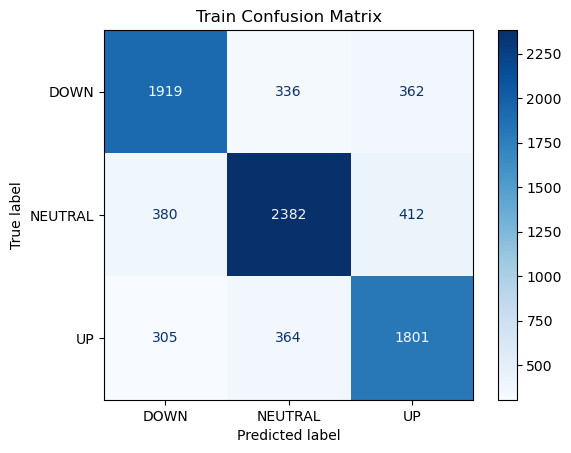

<Figure size 600x600 with 0 Axes>

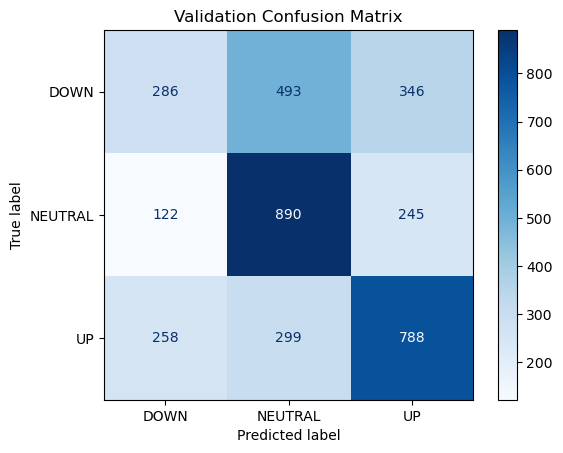

<Figure size 600x600 with 0 Axes>

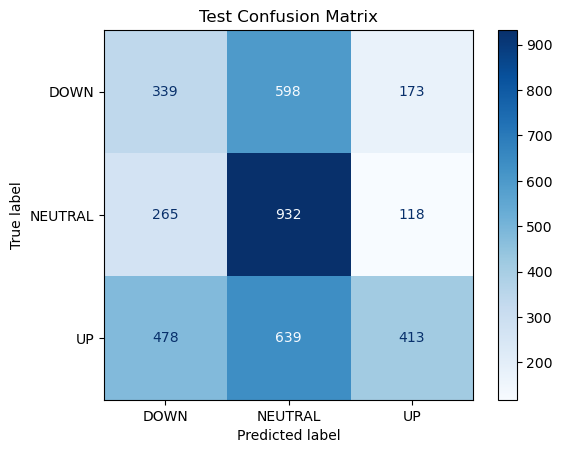

In [122]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ініціалізація моделі
lr = LogisticRegression(
    penalty='l2',
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    n_jobs=-1,
    random_state=42
)

# Навчання
lr.fit(X_train, y_train)

# Прогноз
y_train_pred_lr = lr.predict(X_train)
y_val_pred_lr = lr.predict(X_val)
y_test_pred_lr = lr.predict(X_test)

# Метрики
scores_lr = evaluate_model(
    y_train, y_train_pred_lr,
    y_val, y_val_pred_lr,
    y_test, y_test_pred_lr,
    class_names=le.classes_
)

Модель логістичної регресії показала хороші результати на тренувальному наборі (Macro F1 ≈ 0.74), що свідчить про здатність моделі розрізняти класи на даних, на яких вона навчалася. На валідації та тесті відчутне падіння ефективності (Macro F1 ≈ 0.50 та 0.40), особливо для класів DOWN та UP, тоді як NEUTRAL передбачається значно краще.

Це свідчить про перенавчання (overfitting) на тренувальних даних: модель добре запам’ятала тренувальні приклади, але гірше узагальнює на нових днях. Особливо помітно, що точність передбачень для ринкових змін у обидві сторони (UP/DOWN) знижується, тоді як стабільний стан (NEUTRAL) передбачається краще через більшу частку таких днів у наборі даних.

У підсумку, логістична регресія здатна вловити загальні закономірності, але для кращого прогнозування напрямку руху ціни потрібні більш складні моделі або додаткові фінансові та текстові ознаки для підвищення узагальнювальної здатності.

### LightGBM

In [200]:
from lightgbm import LGBMClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import contextlib, os

# функція для метрик
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1_macro = f1_score(y_true, y_pred, average='macro')
    f1_weighted = f1_score(y_true, y_pred, average='weighted')
    return acc, f1_macro, f1_weighted

# функція для оптимізації
def objective(params):
    for p in ['n_estimators', 'max_depth', 'num_leaves', 'min_child_samples']:
        if p in params: params[p] = int(params[p])

    clf = LGBMClassifier(
        objective='multiclass',
        num_class=len(np.unique(y_train)),
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        verbose=-1,
        **params
    )

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning)

        clf.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='multi_logloss',
            callbacks=[lgb.early_stopping(50, verbose=False)]
        )

        y_train_pred = clf.predict(X_train)
        y_val_pred = clf.predict(X_val)

    _, f1_train, _ = compute_metrics(y_train, y_train_pred)
    _, f1_val, _ = compute_metrics(y_val, y_val_pred)
    
    gap = abs(f1_train - f1_val)
    loss = -f1_val + 0.2 * gap
    return {'loss': loss, 'status': STATUS_OK}

# простір гіперпараметрів
space_lgbm = {
    'n_estimators': hp.quniform('n_estimators', 50, 400, 25),
    'learning_rate': hp.uniform('learning_rate', 0.05, 0.2),
    'max_depth': hp.quniform('max_depth', 3, 5, 1),
    'num_leaves': hp.quniform('num_leaves', 5, 10, 5),
    'min_child_samples': hp.quniform('min_child_samples', 70, 100, 1),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'reg_alpha': hp.uniform('reg_alpha', 0.05, 0.2),
    'reg_lambda': hp.uniform('reg_lambda', 0.05, 0.2),
    'min_split_gain': hp.uniform('min_split_gain', 0, 1)
}

# оптимізація
trials = Trials()
best_lgbm = fmin(fn=objective, space=space_lgbm, algo=tpe.suggest, max_evals=15, trials=trials, show_progressbar=True)

# перетворення int-параметрів
for key in ['n_estimators', 'max_depth', 'num_leaves', 'min_child_samples']:
    best_lgbm[key] = int(best_lgbm[key])

print("Кращі гіперпараметри:", best_lgbm)

# фінальна модель
final_lgbm = LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y_train)),
    random_state=42,
    n_jobs=-1,
    verbose=-1,
    **best_lgbm
)

with contextlib.redirect_stdout(open(os.devnull, 'w')):
    final_lgbm.fit(X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    callbacks=[lgb.early_stopping(50, verbose=False)],
                    eval_metric='multi_logloss')


100%|██████████| 15/15 [00:20<00:00,  1.36s/trial, best loss: -0.4911150108184305]
Кращі гіперпараметри: {'colsample_bytree': 0.9369322524680568, 'learning_rate': 0.1054842413594657, 'max_depth': 5, 'min_child_samples': 85, 'min_split_gain': 0.7053512787605299, 'n_estimators': 50, 'num_leaves': 5, 'reg_alpha': 0.15902077947082438, 'reg_lambda': 0.1173959084468136, 'subsample': 0.8867515974381761}


Для оптимізації гіперпараметрів LGBMClassifier я використовую Hyperopt з алгоритмом TPE. TPE обирає наступні комбінації параметрів на основі попередніх результатів, прагнучи покращити метрику.

Оптимізація мінімізує негативне значення F1 макро на валідаційній вибірці (loss = -f1_macro_val), тобто фактично максимізує F1 макро, що дозволяє знайти гіперпараметри, які забезпечують збалансовану точність для всіх класів у задачі багатокласової класифікації.

Train Macro F1: 0.6829
Validation Macro F1: 0.5321
Test Macro F1: 0.4458
Train metrics:
              precision    recall  f1-score   support

        DOWN       0.80      0.55      0.65      2617
     NEUTRAL       0.66      0.88      0.76      3174
          UP       0.67      0.61      0.64      2470

    accuracy                           0.70      8261
   macro avg       0.71      0.68      0.68      8261
weighted avg       0.71      0.70      0.69      8261

Validation metrics:
              precision    recall  f1-score   support

        DOWN       0.50      0.25      0.34      1125
     NEUTRAL       0.55      0.77      0.64      1257
          UP       0.61      0.63      0.62      1345

    accuracy                           0.56      3727
   macro avg       0.55      0.55      0.53      3727
weighted avg       0.56      0.56      0.54      3727

Test metrics:
              precision    recall  f1-score   support

        DOWN       0.40      0.28      0.33      1110
     NE

<Figure size 600x600 with 0 Axes>

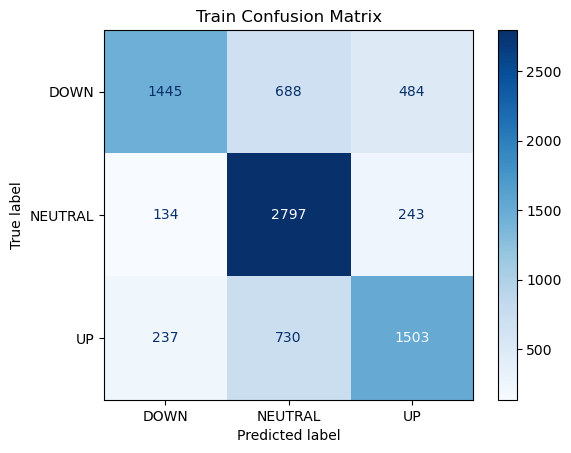

<Figure size 600x600 with 0 Axes>

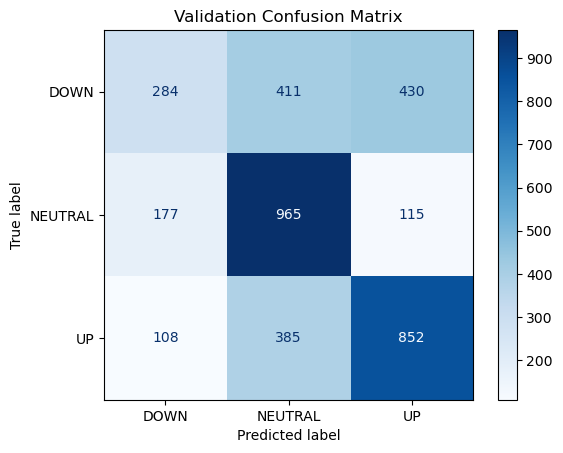

<Figure size 600x600 with 0 Axes>

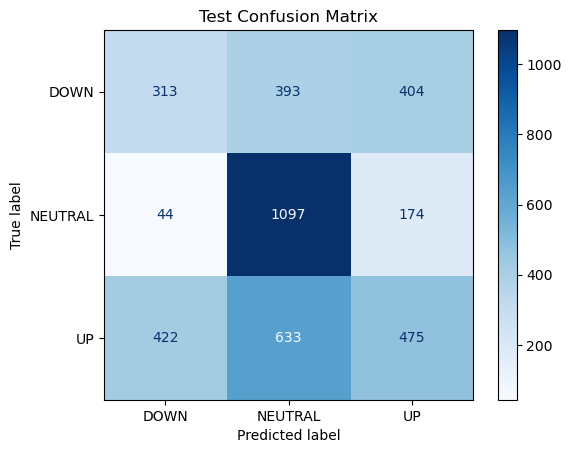

In [205]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore", UserWarning)
    y_train_pred_lgbm = final_lgbm.predict(X_train)
    y_val_pred_lgbm   = final_lgbm.predict(X_val)
    y_test_pred_lgbm  = final_lgbm.predict(X_test)

# Метрики через універсальну функцію
scores_lgbm = evaluate_model(
    y_train, y_train_pred_lgbm,
    y_val, y_val_pred_lgbm,
    y_test, y_test_pred_lgbm,
    class_names=le.classes_
)

Модель показує хороші результати на тренувальних даних (Train Macro F1 ≈ 0.68), але значно гірші на валідації та тесті (Validation Macro F1 ≈ 0.53, Test Macro F1 ≈ 0.45), що свідчить про сильне переобучення; клас NEUTRAL прогнозується найкраще, а DOWN та UP значно гірше, особливо на тесті, accuracy на валідації та тесті ≈ 0.56–0.48 підтверджує слабку узагальнюваність, тому для покращення потрібна додаткова регуляризація, зменшення складності моделі або відбір більш релевантних ознак, при цьому така поведінка також вказує на те, що дані містять слабкі прогностичні сигнали, ринок нестабільний і багато змін ціни не можна точно передбачити лише з наявних фінансових та текстових ознак, можливо, не вистачає обсягу або різноманіття даних, а також можна розглянути ансамблі моделей або часові ознаки для кращої стійкості прогнозів.

In [207]:
import pickle

# Сохраняем финальную модель
with open("final_lgbm_model.pkl", "wb") as f:
    pickle.dump(final_lgbm, f)

# Сохраняем предсказания и метрики (по желанию)
with open("lgbm_preds_metrics.pkl", "wb") as f:
    pickle.dump({
        "y_train_pred": y_train_pred_lgbm,
        "y_val_pred": y_val_pred_lgbm,
        "y_test_pred": y_test_pred_lgbm,
        "scores": scores_lgbm
    }, f)

Топ-фіч для LGBMClassifier:


                     feature  importance
1342               Return_7d          31
1370          Volatility_10d          14
1372                   RSI_7           8
1334            Volume_lag_3           7
1353                   ATR_7           7
1346    Prev_Intraday_Return           7
1385            Volume_Spike           7
1367           Volatility_2d           6
1351            HL_Range_MA7           5
1339               Return_1d           5
1389  Distance_from_High_14d           5
1376          MACD_Histogram           4
1315             Close_lag_7           4
1338           Volume_lag_14           4
1374                    MACD           4
1081              stock news           4
1314             Close_lag_5           4
1321              Open_lag_5           4
1330             High_lag_10           3
1380             BB_Position           3


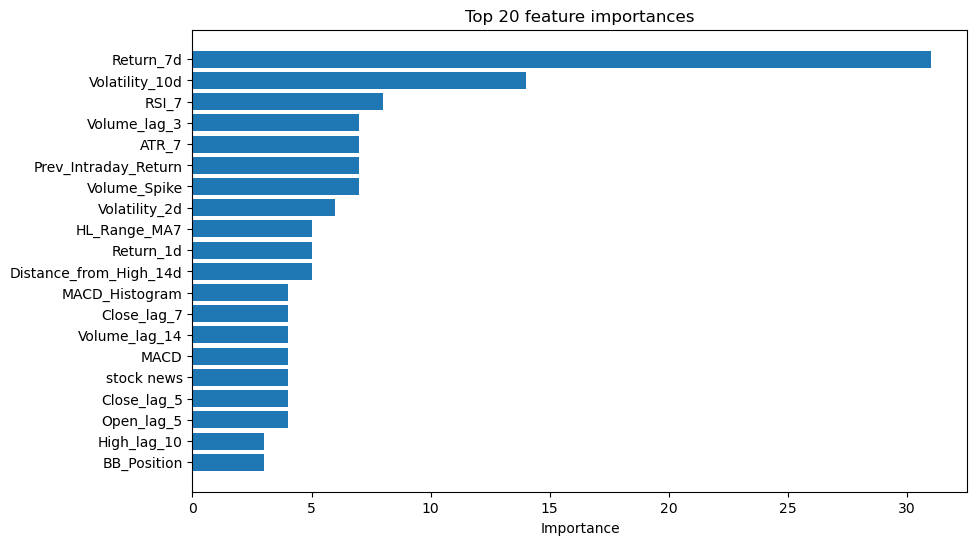

In [216]:
# Отримуємо назви TF-IDF ознак
tfidf_title_features   = tfidf_title.get_feature_names_out()
tfidf_content_features = tfidf_content.get_feature_names_out()

# Додаткові ознаки
extra_features = bin_features + num_features

# Об’єднуємо всі назви
feature_names = np.concatenate([tfidf_title_features, tfidf_content_features, extra_features])

# Важливість ознак за Gain
importances = final_lgbm.feature_importances_
feat_imp_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# Вивід топ-20
print(feat_imp_df.head(20))

# Візуалізація
plt.figure(figsize=(10,6))
plt.barh(feat_imp_df['feature'].head(20)[::-1], feat_imp_df['importance'].head(20)[::-1])
plt.xlabel('Importance')
plt.title('Top 20 feature importances')
plt.show()

Найбільший внесок у прогнозування напрямку зміни ціни мають фінансові ознаки на основі історичних даних, зокрема Return_7d, волатильність за 10 днів та RSI_7, а також обсяги та технічні індикатори (ATR, MACD, HL_Range, BB_Position), при цьому ознаки новин (“stock news”) мають менший, але все ще помітний вплив; це свідчить, що патерни ціни домінують у прогнозі, а сигнали від новин доповнюють модель.

### BERT

In [253]:
#!pip install evaluate

In [80]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

import evaluate
from transformers import DataCollatorWithPadding

In [81]:
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")

id2label = {
    0: "DOWN",
    1: "NEUTRAL",
    2: "UP"
}
label2id = {
    "DOWN": 0,
    "NEUTRAL": 1,
    "UP": 2
}

model = AutoModelForSequenceClassification.from_pretrained(
    "yiyanghkust/finbert-tone",
    num_labels=3,
    id2label=id2label,
    label2id=label2id
)

In [82]:
# заморожуємо параметри базової моделі
for name, param in model.base_model.named_parameters():
    param.requires_grad = False

# і розморожуєм pooling layers - останні, вони і використовуються для класифікації
for name, param in model.base_model.named_parameters():
    if "pooler" in name:
        param.requires_grad = True

In [83]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df[['title','content','target']])
val_dataset = Dataset.from_pandas(val_df[['title','content','target']])
test_dataset = Dataset.from_pandas(test_df[['title','content','target']])

In [85]:
# Визначаємо препроцесинг тексту
def preprocess_function(examples):
    # Можна обʼєднати Title + Content через [SEP] для BERT
    texts = [t + " [SEP] " + c for t, c in zip(examples['title'], examples['content'])]

    return tokenizer(texts, truncation=True, padding=True)
    
def preprocess_function(examples):
    return tokenizer(
        examples["title"],
        examples["content"],
        padding="max_length",
        truncation=True,
        max_length=512
    )

train_dataset = train_dataset.map(preprocess_function, batched=True)
val_dataset = val_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# Переіменування таргет
train_dataset = train_dataset.rename_column("target", "labels")
val_dataset = val_dataset.rename_column("target", "labels")
test_dataset = test_dataset.rename_column("target", "labels")

def encode_labels(example):
    example["labels"] = label2id[example["labels"]]
    return example

train_dataset = train_dataset.map(encode_labels)
val_dataset   = val_dataset.map(encode_labels)
test_dataset  = test_dataset.map(encode_labels)

Map:   0%|          | 0/8261 [00:00<?, ? examples/s]

Map:   0%|          | 0/3727 [00:00<?, ? examples/s]

Map:   0%|          | 0/3955 [00:00<?, ? examples/s]

Map:   0%|          | 0/8261 [00:00<?, ? examples/s]

Map:   0%|          | 0/3727 [00:00<?, ? examples/s]

Map:   0%|          | 0/3955 [00:00<?, ? examples/s]

In [88]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")  

def compute_metrics(eval_pred):
    """Обчислює метрики під час тренування"""
    predictions, labels = eval_pred

    predicted_classes = np.argmax(predictions, axis=1)

    # Accuracy
    acc = accuracy_metric.compute(predictions=predicted_classes,references=labels)['accuracy']

    # F1 scores через evaluate
    f1_macro = f1_metric.compute(predictions=predicted_classes,references=labels,average='macro')['f1']

    f1_weighted = f1_metric.compute(predictions=predicted_classes,references=labels,average='weighted')['f1']

    return {
        'accuracy': acc,
        'f1_macro': f1_macro,
        'f1_weighted': f1_weighted
    }

Нижче наведено код який виконує підбір гіперпараметрів моделі FinBERT за допомогою бібліотеки Optuna. Підбираються оптимальні значення learning rate, batch size та weight decay. Для кожної комбінації параметрів модель ініціалізується заново, навчається на тренувальному наборі та оцінюється на валідаційному за метрикою F1-macro.

Далі модель зберігається, завантажується та робляться predictions.

Не дочекалась виконання із-за технічних збоїв, тому нижче за цим просто виконала навчання на 10 епохах для заданих гіперпараметрів без підбору.

In [110]:
#pip install optuna

In [ ]:
from transformers import Trainer, TrainingArguments
import optuna

def model_init():
    return AutoModelForSequenceClassification.from_pretrained(
        "yiyanghkust/finbert-tone", num_labels=3
    )

# TrainingArguments
training_args = TrainingArguments(
    output_dir="finbert-classifier",
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=5,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",
    dataloader_pin_memory=False,
)

# Функція гіперпараметрів для Optuna
def hp_space_optuna(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 5e-5, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [8, 16]),
        "weight_decay": trial.suggest_float("weight_decay", 0.0, 0.1),
    }
    
# Trainer
trainer = Trainer(
    model_init=model_init,  
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

# Hyperparameter search
best_run = trainer.hyperparameter_search(
    direction="maximize",
    backend="optuna",
    n_trials=5,
    hp_space=hp_space_optuna,
)

print(best_run)

![](3.png)

In [ ]:
# Оновлюємо args
trainer.args.learning_rate = best_run.hyperparameters["learning_rate"]
trainer.args.per_device_train_batch_size = best_run.hyperparameters["per_device_train_batch_size"]
trainer.args.weight_decay = best_run.hyperparameters["weight_decay"]

trainer.model = trainer.model_init()

trainer.train()

In [150]:
# Збереження моделі
trainer.model.save_pretrained("finbert-trained")

# Збереження токенайзера
trainer.tokenizer.save_pretrained("finbert-trained")

Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


('finbert-trained/tokenizer_config.json',
 'finbert-trained/special_tokens_map.json',
 'finbert-trained/vocab.txt',
 'finbert-trained/added_tokens.json',
 'finbert-trained/tokenizer.json')

Тут мають бути підібрані гіперпараметри, але поки навчаю базово модель:

In [148]:
# hyperparameters
lr = 2e-4
batch_size = 8
num_epochs = 8

training_args = TrainingArguments(
    output_dir="finbert-classifier",
    learning_rate=lr,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=num_epochs,
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    report_to="none",
    dataloader_pin_memory=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

/var/folders/39/m96sys4d427_kqtfqwm8bwn00000gn/T/ipykernel_2309/2078833779.py:22: FutureWarning:

`tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.



TrainOutput(global_step=8264, training_loss=1.089184549632631, metrics={'train_runtime': 4019.7366, 'train_samples_per_second': 16.441, 'train_steps_per_second': 2.056, 'total_flos': 1.7388639550808064e+16, 'train_loss': 1.089184549632631, 'epoch': 8.0})

In [154]:
def evaluate_bert(trainer, train_dataset=None, val_dataset=None, test_dataset=None):
    """
    Функція для оцінки моделі finbert на трьох датасетах: train, val, test.
    Виводить classification report, confusion matrix і F1 macro.
    """
    datasets = {
        "Train": train_dataset,
        "Validation": val_dataset,
        "Test": test_dataset
    }

    for name, dataset in datasets.items():
        if dataset is None:
            continue

        print(f"\n=== {name} Dataset ===")
        trainer.args.per_device_eval_batch_size = 32  # швидкі батчі

        # Прогноз
        predictions = trainer.predict(dataset)
        pred_labels = predictions.predictions.argmax(-1)

        # Справжні мітки
        true_labels = dataset["labels"]

        # F1 macro
        f1_macro = f1_score(true_labels, pred_labels, average='macro')
        print(f"F1 macro: {f1_macro:.3f}")

        # Classification report
        print("Classification Report:")
        print(classification_report(true_labels, pred_labels, digits=3))

        # Confusion matrix
        cm = confusion_matrix(true_labels, pred_labels)
        plt.figure(figsize=(5,4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2])
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title(f"{name} Confusion Matrix")
        plt.show()


=== Train Dataset ===
F1 macro: 0.462
Classification Report:
              precision    recall  f1-score   support

           0      0.571     0.255     0.353      2617
           1      0.496     0.658     0.566      3174
           2      0.433     0.505     0.466      2470

    accuracy                          0.485      8261
   macro avg      0.500     0.473     0.462      8261
weighted avg      0.501     0.485     0.469      8261



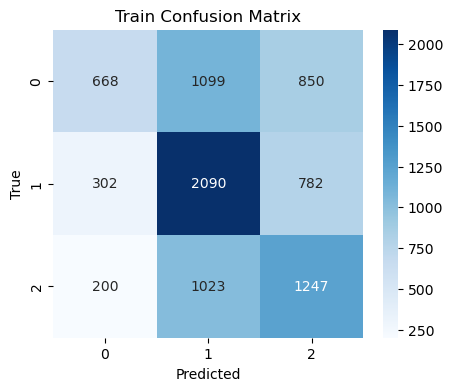


=== Validation Dataset ===


F1 macro: 0.325
Classification Report:
              precision    recall  f1-score   support

           0      0.263     0.139     0.182      1125
           1      0.355     0.481     0.408      1257
           2      0.375     0.399     0.386      1345

    accuracy                          0.348      3727
   macro avg      0.331     0.339     0.325      3727
weighted avg      0.334     0.348     0.332      3727



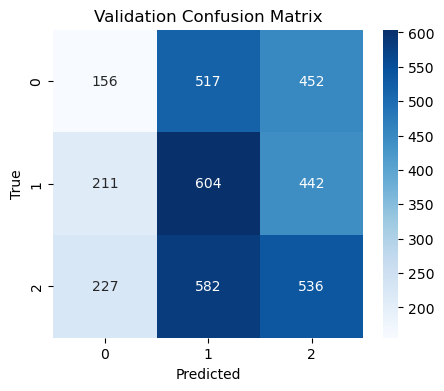


=== Test Dataset ===


F1 macro: 0.352
Classification Report:
              precision    recall  f1-score   support

           0      0.342     0.250     0.289      1110
           1      0.359     0.532     0.428      1315
           2      0.384     0.300     0.337      1530

    accuracy                          0.363      3955
   macro avg      0.362     0.361     0.352      3955
weighted avg      0.364     0.363     0.354      3955



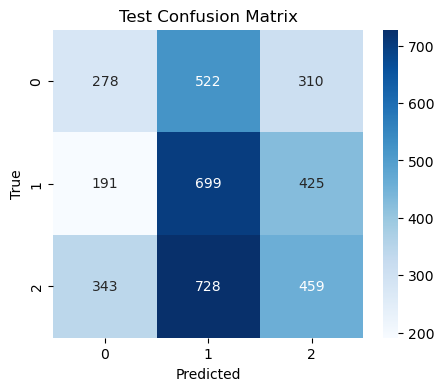

In [162]:
evaluate_bert(trainer, train_dataset, val_dataset, test_dataset)

Модель на основі BERT демонструє обмежену узагальнювальну здатність на задачі мультикласової класифікації. На тренувальному наборі досягається F1-macro = 0.462, тоді як на валідаційному та тестовому наборах значення метрики знижуються до 0.325 та 0.352 відповідно, що свідчить про перенавчання моделі.

Найкраще модель розпізнає клас Neutral (1), для якого спостерігається вищий recall на всіх датасетах. Водночас класи Down (0) та Up (2) класифікуються гірше, що може бути пов’язано з субʼєктивно визначеним таргетом та обмеженою інформативністю текстових даних.

Загальна точність та F1-macro на тестовому наборі залишаються близькими до baseline, що вказує на те, що використання лише текстових ознак (BERT) є недостатнім для цієї задачі. Це підтверджує доцільність гібридного підходу, який поєднує текстові дані з числовими фінансовими індикаторами та класичними ML-моделями.

### LLM

In [ ]:
import json
import os
from openai import OpenAI
from sklearn.metrics import f1_score, accuracy_score
from tqdm import tqdm

with open('creds.json') as file:
  creds = json.load(file)

os.environ["OPENAI_API_KEY"] = creds["OPENAI_API_KEY2"]
client = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

def predict_llm(row):
    news_type = "Opinion" if row['category'] == "opinion" else "News"

    system_prompt = f"""
You are a financial news analyst predicting NEXT-DAY stock price movement.

This is a {news_type} article.

IMPORTANT CONTEXT:
- The dataset is BALANCED (DOWN / NEUTRAL / UP).
- Most news does NOT move prices significantly.
- NEUTRAL is the default outcome unless there is evidence of price impact.

TASK:
Predict the IMMEDIATE (next-day) price impact of THIS news.

CLASSIFICATION RULES:

DOWN →
- Clear negative catalyst
- OR even moderate increase in downside risk, uncertainty, or disappointment
- OR partial removal of a positive narrative
- OR negative trend indicated in recent price context
- Choose DOWN even if the negative impact is subtle, as long as it could influence price

UP →
- Requires a CLEAR, CONCRETE, SHORT-TERM POSITIVE CATALYST
- Examples:
  * earnings beat
  * revenue / guidance upgrade
  * contract win
  * regulatory approval
  * acquisition at premium
- Absence of bad news is NOT a reason for UP

NEUTRAL →
- No clear short-term catalyst
- Opinion, commentary, or analysis
- Mixed or uncertain signals
- Long-term narratives
- Already expected or priced-in information

DECISION PRIORITY:
1) If there is clear or moderate negative/asymmetric risk → DOWN
2) Else if there is a concrete short-term positive catalyst → UP
3) Else → NEUTRAL

CRITICAL RULES:
- Do NOT choose UP unless a specific catalyst is present
- Do NOT infer UP from optimistic tone alone
- When in doubt → choose NEUTRAL

Respond with ONLY ONE WORD:
DOWN, NEUTRAL, or UP
"""
    prompt = f"Title: {row['title']}\n\nContent: {row['content']}"
    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": prompt}
        ],
        temperature=0
    )
    prediction = response.choices[0].message.content.strip().upper()

    return prediction

In [ ]:
tqdm.pandas(desc="GPT-3.5 predictions")

test_df['llm_pred'] = test_df.progress_apply(predict_llm, axis=1)

test_df_results = test_df[['Date', 'title', 'content', 'target', 'llm_pred']].copy()
test_df_results.to_csv('llm_results_test.csv', index=True)

Test Macro F1: 0.3367
Test metrics:
              precision    recall  f1-score   support

        DOWN       0.27      0.27      0.27      1110
     NEUTRAL       0.36      0.31      0.33      1315
          UP       0.39      0.43      0.41      1530

    accuracy                           0.35      3955
   macro avg       0.34      0.34      0.34      3955
weighted avg       0.35      0.35      0.34      3955



<Figure size 600x600 with 0 Axes>

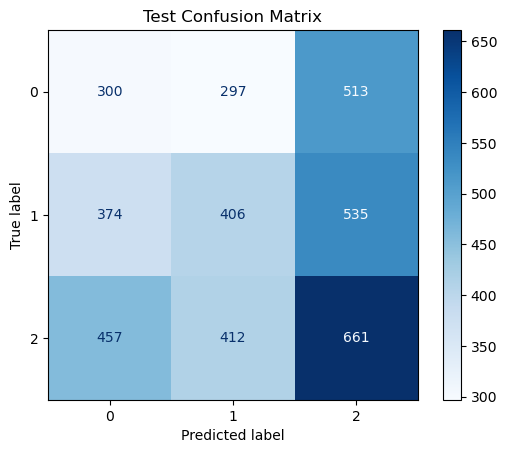

In [227]:
# завантажую збережений CSV з результатами моделі на тесті
test_df_results = pd.read_csv('llm_results_test.csv', index_col=0)
y_test = test_df_results['target']
y_test_pred = test_df_results['llm_pred']

# F1 макро
print(f"Test Macro F1: {f1_score(y_test, y_test_pred, average='macro'):.4f}")

# classification report
print("Test metrics:")
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
plt.figure(figsize=(6,6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Test Confusion Matrix")
plt.grid(False)
plt.show()

Результати показують, що модель GPT-3.5 для прогнозування наступного дня змін ціни акцій працює слабко: Test Macro F1 ≈ 0.34, точність класів DOWN та NEUTRAL дуже низька (≈0.27–0.33), UP трохи кращий (≈0.41), accuracy всього 0.35. Це свідчить, що модель погано розрізняє класи, особливо коли сигнал слабкий або неоднозначний. Найімовірніше, основні проблеми пов’язані з тим, що:

	• важкий таргет для прогнозування без фін.контексту (краще працює для UP/DOWN)
	• більшість новин не дають сильного сигналу до зміни ціни
	• LLM працює тільки з текстом, не враховуючи часові ряди, технічні індикатори чи контекст попередніх цін;
	• dataset дуже збалансований, але ринок у реальному житті нерівномірний, що ускладнює навчання на конкретних паттернах.

Що треба покращити: 

	• додати лагові ознаки та контекст попередніх днів, щоб LLM бачив, що відбувалося з ціною перед новиною - але не в числовому а текстовому вигляді агрегувавши та оцінивши словами фінансові дані
	• додати прикладів до промпту
	• доопрацювати промпт задля зменшення передбачення UP	

### Порівняння моделей

![](4.png)

    1. Baseline – показник випадкового вгадування, метрики рівні 0.33.
	2. Logistic Regression (text + finance) – значно перевищує baseline, швидка у навчанні, добре поєднує текстові та фінансові дані, але F1 можна покращити. Перенавчена.
	3. LGBM (text + finance) – трохи поступається логістичній регресії за першою метрикою,але краща тим що перенавчання суттєво менше, краща на валідації та тесті, демонструє збалансовані результати, ефективний для складних взаємозв’язків у даних.
	4. FinBERT (text only) – не дав результатів у тесті, ймовірно через обмеження лише текстових даних. Пошук гіперпараметрів займає дуже багато часу тому зроблено мало ітерацій.
	5. GPT-3.5 turbo (text only) – показує низьку точність (0.3367) - рандом, навчання та тест займають багато часу і коштують грошей, ефективність невисока без інтеграції фінансових даних. 

### Висновки

У межах проєкту було реалізовано підхід до прогнозування ринкового руху на основі поєднання текстових фінансових новин та числових індикаторів. Було досліджено кілька моделей машинного навчання, зокрема класичні ML-алгоритми (Logistic Regression, LightGBM), Transformer-моделі для роботи з текстом (FinBERT), а також підхід із використанням LLM через API. Якість моделей оцінювалась за метрикою F1-macro з використанням окремих train, validation та test вибірок.

Отримані результати показали, що моделі, які поєднують текстові та числові ознаки, демонструють вищу стабільність і кращу узагальнювальну здатність, ніж моделі, побудовані лише на тексті. Transformer-модель та GPT, що використовують тільки новинні тексти, не забезпечили суттєвого приросту якості порівняно з baseline. Це підтверджує, що для задач фінансового прогнозування однієї текстової інформації недостатньо, і необхідний комплексний підхід. (Але модель Bert показала кращий результат на train, тож якщо підібрати гіперпараметри та донавчити, може бути перспективною).

Проєкт є дослідницьким прототипом, що підтверджує доцільність поєднання новин та технічних індикаторів, однак потребує подальшого розвитку для промислового використання через обмеження в даних, відсутність повноцінного backtesting, спрощену обробку текстової інформації, недостатній рівень feature engineering, необхідність більш ретельного навчання моделей та перегляду формулювання цільової змінної.

**Можливі напрямки покращення**	

    • Додати макроекономічні показники (індекси, валютні курси, процентні ставки).
	• Використати більш складні методи обробки пропущених значень.
	• Застосувати кілька алгоритмів аналізу тональності та використовувати агреговані sentiment-scores.
	• Додати Named Entity Recognition (NER) для виділення компаній, персон та ключових подій у новинах.
	• Враховувати волатильність ринку, обсяги торгів та інші ринкові режими при роботі з LLM.
	• Вирішити проблему нерівномірної кількості новин, зокрема шляхом використання LLM через API для агрегації новин за день (формування одного узагальненого тексту на день).
	• Реалізувати часові моделі (LSTM) для прогнозування динаміки та поєднати їх з LightGBM у вигляді ансамблю або stacking-підходу.
	• Використовувати time-series cross-validation, ранню зупинку та backtesting для контролю перенавчання.

**Перспективи розвитку**

Перспективним напрямком розвитку є побудова гібридної системи, яка поєднує:

	• часові моделі (LSTM / Transformer) для аналізу ринкової динаміки,
	• класичні ML-моделі для роботи з числовими ознаками,
	• NLP-модулі для виділення тональності та ключових подій із новин,
	• ансамблювання результатів для підвищення стабільності прогнозів.

А далі розширити проєкт на декілька тикерів.